# Hoda Nabavi

# Introduction:
'Kickstarter' is one of the most popular platforms for promoting and bringing to life creative projects and thus 150,836 projects have been funded since the company's launch in 2009. Each project does this by seeking funding from the Kickstarter crowd to support their idea and hopefully see it succeed.



# Hypothesis


In this notebook, I will share my analysis of a dataset of roughly 375,000 Kickstarter projects and I would like to predict which projects are successfully funded, based on their categorical characteristics. This information could be used to see if the projects are meeting the financial goals that they need to succeed and if a project is on track to being funded or failing.


# About the Dataset 

Downloaded from Kaggle.com


The original dataset contains 378,661 projects from Kickstarter website. Including the following data:


Name - The name of the project

Main category - The main Category of the project

Category - The Subcategory of the main Category

Country - The country of the project

Launched - Date the project was launched on Kickstarter

Deadline - Deadline date for the project

Goal - The monetary goal for the project in (USD)

Pledged - The amount pledged to the project (USD)

Backers - The amount of contributors

State - The state of the project i.e. Successful, Failed

Consists of 15 variables with 378661 observations






In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from scipy import stats, special
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection
from seaborn import pairplot, heatmap

In [5]:
df = pd.read_csv('ks-projects-201801.csv')
df.head(5)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# Data Preparation:


## Step 1: Variables
Identifiying the highly correlated and uniformative variables and dropping them.

### Time-series variables
 - `launched` , `deadline`

### Categorical variables
  
 - `uninformative` : `name`, `category`(too many unique values), `currancy` (related to country)
  
### Numeric variables
 - `uninformative` : `ID` 
 - `correlated`: 
  * `goal` , `usd_goal_real` , `usd_goal_real` (keep `usd_goal_real`)
  * `pledged` , `usd pledged` , `usd_pledged_real` (keep `usd_pledged_real`)

 $ The `real` value is the currency convertion based on some financial institution.
 

  
  
             



In [6]:
# datetime conversions
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])

In [7]:
df.select_dtypes(include = 'object').nunique()

name             375764
category            159
main_category        15
currency             14
state                 6
country              23
dtype: int64

### Target variable

In order to work easier with the state of the project as the `target` variable of this project, the catagerical values of the `state` column is changed to numerical values.



<AxesSubplot:>

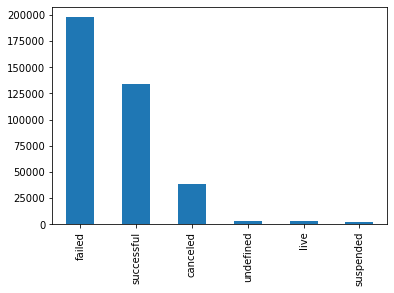

In [8]:
df['state'].value_counts().plot(kind='bar')

In [9]:
# Keep the projects which are succeccful or failed

df1= df.loc[(df['state'] == 'failed') | (df['state'] == 'successful')]
df1.reset_index(inplace=True, drop=True) 


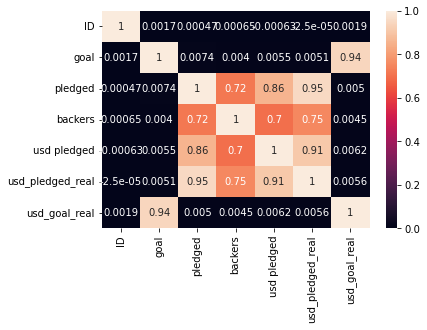

In [10]:
heatmap(df.corr(),annot = True);

In [11]:
# Drop highly correlated and uniformative variables
df1=df1.drop(columns = ['name','category','currency','goal','pledged','usd pledged','ID'])


### Step 2: Values

- `NaN` values
- `Duplicated` data



In [12]:
df1.isnull().sum()

main_category       0
deadline            0
launched            0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

In [13]:
df1.duplicated().sum()

0

In [14]:
df1.describe()

,backers,usd_pledged_real,usd_goal_real
count,331675.000000,3.316750e+05,3.316750e+05
mean,116.381581,9.943461e+03,4.151000e+04
std,965.427268,9.673293e+04,1.108930e+06
min,0.000000,0.000000e+00,1.000000e-02
25%,2.000000,5.000000e+01,2.000000e+03
50%,15.000000,7.880000e+02,5.000000e+03
75%,63.000000,4.608000e+03,1.500000e+04
max,219382.000000,2.033899e+07,1.663614e+08


### numeric variables 
We can see that the mean number of people supporting each project (backers) was 116 with a minimum value of 0 supporters for failed projects and a maximum of 219382, the standard deviation was pretty big  965 supporters.

The other interesting variable is the pledged amount in USD with a mean value of 9943 USD and a standard deviation of 96732 USD, which is probably caused by the very high maximum value.

A similar pattern in data is for the goals of Kickstarter projects, the mean value is around 41510 USD with a very high maximum value and big standard deviation.


##### The focus of this project is on categorical variables, so more analysis is skipped.




# Primary questions

1. What country has the highest success rate of projects?
2. Which category has the highest success percentage? 



In [15]:
country= pd.DataFrame()
country['All_state'] = pd.DataFrame(df.groupby(df['country'])['state'].agg(len))
country['success_state'] =  pd.DataFrame(df.groupby(df[df['state']=='successful']['country'])['state'].agg(len))
country['rate'] = (country['success_state'] / country['All_state'] * 100).round(1)
country = country.sort_values('rate',ascending=False).reset_index()
country.head(10)

,country,All_state,success_state,rate
0,US,292627,109299,37.4
1,GB,33672,12067,35.8
2,HK,618,216,35.0
3,DK,1113,360,32.3
4,SG,555,178,32.1
5,NZ,1447,448,31.0
6,FR,2939,908,30.9
7,LU,62,19,30.6
8,SE,1757,509,29.0
9,CA,14756,4134,28.0


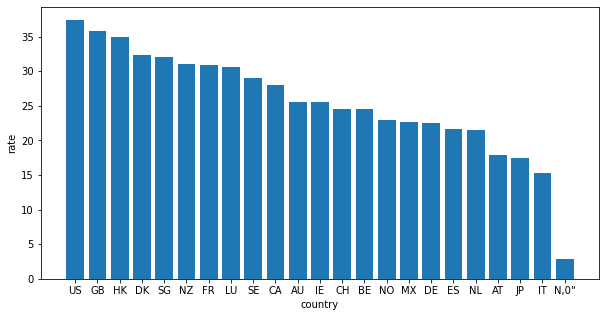

In [16]:
plt.figure(figsize=(10,5))
plt.bar(country['country'], country['rate'])
plt.xlabel('country')
plt.ylabel('rate')
plt.show()

In [17]:
category= pd.DataFrame()
category['All_state'] = pd.DataFrame(df.groupby(df['main_category'])['state'].agg(len))
category['success_state'] =  pd.DataFrame(df.groupby(df[df['state']=='successful']['main_category'])['state'].agg(len))
category['rate'] = (category['success_state'] / category['All_state'] * 100).round(1)
category = category.sort_values('rate',ascending=False).reset_index()
category.head(10)

,main_category,All_state,success_state,rate
0,Dance,3768,2338,62.0
1,Theater,10913,6534,59.9
2,Comics,10819,5842,54.0
3,Music,51918,24197,46.6
4,Art,28153,11510,40.9
5,Film & Video,63585,23623,37.2
6,Games,35231,12518,35.5
7,Design,30070,10550,35.1
8,Publishing,39874,12300,30.8
9,Photography,10779,3305,30.7


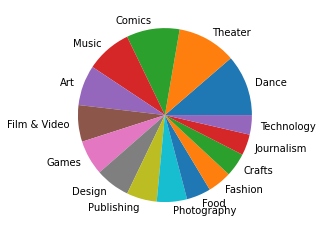

In [18]:
plt.figure()
#plt.bar(category['main_category'][:10],category['rate'][:10])
plt.pie(category['rate'],labels=category['main_category'])
#plt.xlabel('category')
#plt.ylabel('rate')
plt.show()

# Classification Modeling

### Preparation

- Encoding: One-hot encoding of categorical variables (`country` and `main category`) 
- Converting `state` to binary (`successful` : 1 , `failed` : 0)
- Split data to train and test

In [19]:
# encoding categorical variables

from sklearn.preprocessing import OneHotEncoder

## remove 'deadline','launched' column for now, as we won't use them for classification analysis 
df2 = df1.drop(columns=['deadline','launched','state'])


## list of categorical columns
cat_cols = df2.select_dtypes(include='object').columns

## df of categorical variables only
df2_cat = df2[cat_cols]

## one-hot encoding
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(df2_cat)
df2_enc = pd.DataFrame(enc.transform(df2_cat))

## add back column names
df2_enc.columns = enc.get_feature_names_out(cat_cols)

## join with numerical columns
df_final = pd.concat([df1.state,df2.drop(columns=cat_cols,axis=1),df2_enc],axis = 1)


In [20]:
# state to binary (0: failed, 1: successful)

df_final['state'] = df_final['state'].replace({'failed':0, 'successful':1})
df_final['state']=df_final['state'].astype('int')


In [21]:
## shape 
print('Initial size: ', df.shape)
print('Final data size: ' ,df_final.shape)

Initial size:  (378661, 15)
Final data size:  (331675, 42)


In [22]:
df_final.head()

,state,backers,usd_pledged_real,usd_goal_real,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,0,0.0,1533.95,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,15,2421.0,30000.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,3,220.0,45000.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,1,1.0,5000.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,224,52375.0,50000.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [23]:
X = df_final.drop(columns = ['state','usd_pledged_real','usd_goal_real','backers']) # drop the target variables 
y = df_final['state']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=99)

In [24]:
results = [0,0,0]

### Logistic Regression

In [25]:
# Define a range of depth values to try
C_values = [0.01,0.1,1,10,100]


train_scores_log = []
test_scores_log = []


# Loop through each C value
for d in C_values:

    # Create and fit a logistic regression with that C
    df_log_model = linear_model.LogisticRegression(solver='liblinear',C=d)
    df_log_model.fit(X_train, y_train)

    
    train_acc_log = df_log_model.score(X_train, y_train)
    test_acc_log = df_log_model.score(X_test, y_test)

    train_scores_log.append(train_acc_log)
    test_scores_log.append(test_acc_log)


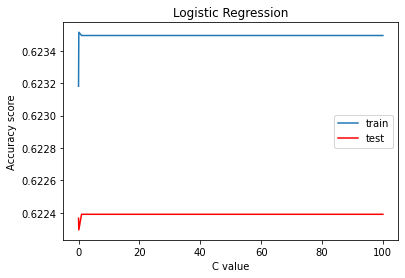

In [26]:
plt.figure()
plt.plot(C_values, train_scores_log, label='train')
plt.plot(C_values, test_scores_log, label='test', c='r')
plt.xlabel('C value')
plt.ylabel('Accuracy score')
plt.legend()
plt.title('Logistic Regression')
plt.show()

Based on the graph, the optimal value of `C` for `logistic regression` model is `1`.

In [719]:
df_log_model = linear_model.LogisticRegression(solver='liblinear',C=1.0)
df_log_model.fit(X_train, y_train)

print(df_log_model.score(X_train, y_train))

df_log_model.fit(X_test, y_test)

results[0] = df_log_model.score(X_test, y_test)

print(results[0])

0.6234945086751676
0.622318165920959


### Random Forest Classifier

In [683]:
# Define a range of depth values to try
depth_values = range(1, 15)

# Create placeholder lists to append our scores to
train_scores_rf = []
test_scores_rf = []


# Loop through each depth value
for d in depth_values:

    # Create and fit a random forest with that depth
    clf = RandomForestClassifier(criterion = 'entropy',
                             max_depth=d, 
                             random_state=5)
    clf.fit(X_train, y_train)

    # Calculate train and test accuracies
    train_acc_rf = clf.score(X_train, y_train)
    test_acc_rf = clf.score(X_test, y_test)

    # Append them to our lists
    train_scores_rf.append(train_acc_rf)
    test_scores_rf.append(test_acc_rf)

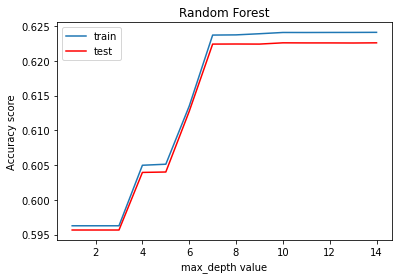

In [684]:
plt.figure()
plt.plot(depth_values, train_scores_rf, label='train')
plt.plot(depth_values, test_scores_rf, label='test', c='r')
plt.xlabel('max_depth value')
plt.ylabel('Accuracy score')
plt.legend()
plt.title('Random Forest')
plt.show()

Based on the graph, the optimal value of `max depth`for `Random Forest` model is `7`.

In [687]:
clf = RandomForestClassifier(criterion = 'entropy',
                             max_depth=7, 
                             random_state=5)
clf.fit(X_train, y_train)
#clf.feature_importances_
print(clf.score(X_train, y_train))

clf.fit(X_test, y_test)
#clf.feature_importances_
results[1] = clf.score(X_test, y_test)

print(results[1])

0.6237115888661982
0.622704084709174


# Desicion tree modeling

In [681]:
# Define a range of depth values to try
depth_values = range(1, 15)

# Create placeholder lists to append our scores to
train_scores_dt = []
test_scores_dt = []


# Loop through each depth value
for d in depth_values:

    # Create and fit a decision tree with that depth
    dt = tree.DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    # Calculate train and test accuracies
    train_acc_dt = dt.score(X_train, y_train)
    test_acc_dt = dt.score(X_test, y_test)

    # Append them to our lists
    train_scores_dt.append(train_acc_dt)
    test_scores_dt.append(test_acc_dt)

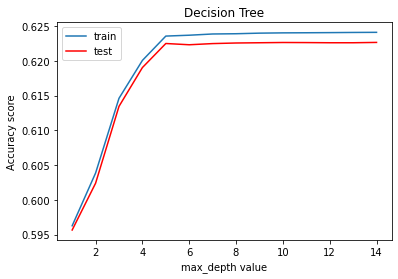

In [682]:
plt.figure()
plt.plot(depth_values, train_scores_dt, label='train')
plt.plot(depth_values, test_scores_dt, label='test', c='r')
plt.xlabel('max_depth value')
plt.ylabel('Accuracy score')
plt.legend()
plt.title('Decision Tree')
plt.show()

Based on the graph, the optimal value of `max depth`for `decision tree` model is `5`.

In [679]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)
print(dt.score(X_train, y_train))

dt.fit(X_test, y_test)
results[2] = dt.score(X_test, y_test)
print(results[2])

0.6235668687388445
0.6192549355395024


## Insights
The Logistic regresion and Random forest work similar on this dataset but the accuracy of the Decision tree model is bit less that others. In general, we can say that all the models have similar results for the datasets. But predicting the success or failure of projects needs some additional work would be needed to in case of adding some numeric variables to improve the model.

In [720]:
my_data = pd.DataFrame({'Model': ['Logistic Regression', 'Random Forest','Decision Tree'],' Accuracy score': [results[0], results[1],results[2]]})
my_data

,Model,Accuracy score
0,Logistic Regresion,0.622318
1,Random Forest,0.622704
2,Decision Tree,0.619255
